### Download an read in sensor data with some case specific metadata

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sensordata
sns.set_style(style='whitegrid')

datasets, features_sets, target_sets, metadata = sensordata.load_and_preprocess_data(validationset=False, savecsv=False, sensorset='FIS')
calibrationset = datasets[0]
calibration_features_matrix = features_sets[0]
calibration_co_cons = target_sets[0]
cal_experiment_matrix, cal_targets = sensordata.postprocess_data(calibration_features_matrix, calibration_co_cons)

/home/dreuter/Github/kaggle-paths/gas-sensor-array/data/gas-sensor-data.zip
already exists, file not downloaded
csv files already exists in
/home/dreuter/Github/kaggle-paths/gas-sensor-array/data,
no files extracted
Starting to import and preprocess sensor data from 20160930_203718.csv
The shape of features matrix is:
(2020, 306)
20160930_203718.csv successfully imported
 
Calibration set only has been loaded in 12.212484359741211 seconds
with preprocessingset to: True
Postprocessing data matrix into subtarget concentration samples ..
Postprocessing done.


### Added features
  * **HeatingCycle** -- Shows where in the heating cycle response signal datapoint is measured 
  * **Preprocessed signals matrix** (features_sets, co_cons_sets) -- Logarithmic transformed response data from the **7 FIG sensors** and/or **6 FIS sensors**, where each row contains a **log linear part cycle response** for a selected range of the signal where the respons comes from the 25 second measurments cycle in the collected data [chopped between approximatley 10 seconds, 20 seconds]. Each cycle collects to a total of around **200-500 datapoints** and corresponds to a target concentration value collected in a separate array.  
 **Postprocessed signal matrix** --  

## Visualization of stacked signals in feature matrix

In [6]:
cal_experiment_matrix.shape

(100, 6120)

In [7]:
pd.DataFrame(cal_experiment_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,6110,6111,6112,6113,6114,6115,6116,6117,6118,6119
0,-4.053328,-4.154434,-4.106943,-3.935907,-3.943136,-4.193959,-4.127373,-4.090106,-4.100643,-3.954253,...,-2.543073,-2.132117,-1.803820,-2.210360,-2.210360,-2.210360,-2.210360,-2.210360,-2.210360,-2.210360
1,-2.891554,-2.747527,-2.831836,-2.821278,-2.627541,-2.886152,-2.886776,-2.757558,-2.855452,-2.831936,...,-2.609231,-2.609231,-2.609231,-2.609231,-2.609231,-2.609231,-2.609231,-2.609231,-2.609231,-2.609231
2,-3.170866,-3.091583,-3.118662,-3.093712,-2.917414,-3.185910,-3.177062,-3.086254,-3.135168,-3.093712,...,-2.667388,-2.296235,-1.992303,-2.357376,-2.389661,-2.172157,-2.649305,-2.276334,-1.976675,-2.346085
3,-2.991639,-2.911883,-2.933213,-2.916916,-2.724114,-2.997091,-2.999286,-2.902838,-2.959099,-2.921467,...,-3.612349,-3.403192,-3.333721,-3.614581,-3.392779,-3.441590,-3.608423,-3.403192,-3.297103,-3.563064
4,-3.817374,-3.966782,-3.876665,-3.782968,-3.751723,-3.973585,-3.840387,-3.925533,-3.894020,-3.778359,...,-2.945018,-2.637048,-2.373332,-2.681713,-2.657045,-2.527016,-2.937833,-2.617556,-2.357831,-2.670549


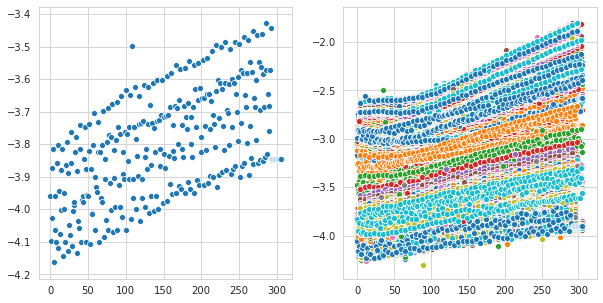

In [8]:
day = 1
fig, axes = plt.subplots(1,2, figsize=(10,5))
signalsample = 1
signalconc = target_sets[day-1][signalsample]
signal = features_sets[day-1][signalsample,:]
nsig = len(signal)
sns.scatterplot(np.arange(nsig),signal, ax=axes[0])

signalconcs = target_sets[day-1]
signals = features_sets[day-1]
nsig = len(signals)
for signal in signals[:100]:
    nsig = len(signal)
    sns.scatterplot(np.arange(nsig),signal, ax=axes[1])
plt.show()

# Projection to latent structures modelling
A.K.A Projection least squares  
using the logarithmic transformed sensor response signal

[1.19367731 1.03907732 0.828672   0.6224222  0.56333191 0.58743456
 0.55490538 0.56379188 0.57671675]


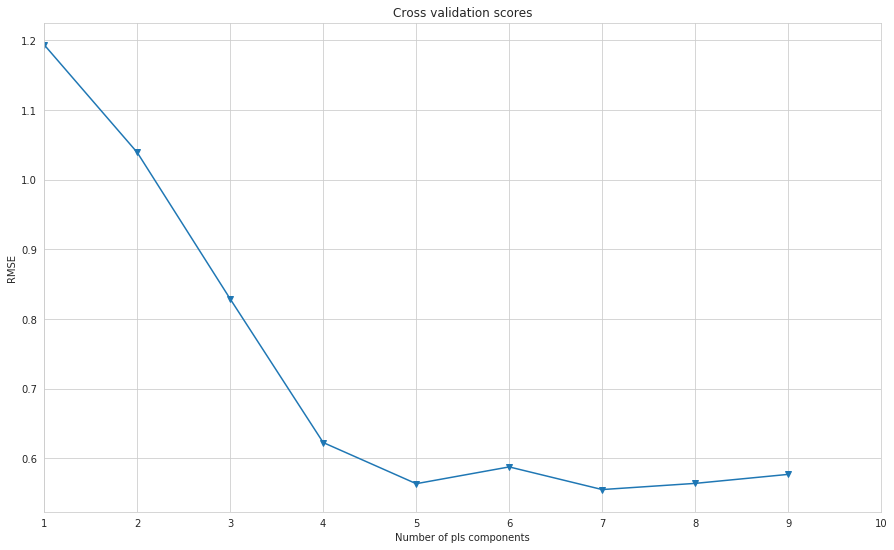

In [9]:
from sklearn import model_selection
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

signals = calibration_features_matrix

X = cal_experiment_matrix
y = cal_targets

test_size = 0.2
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=42)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

rmse = []

min_lv = 1
max_lv = 10
comprange = np.arange(min_lv, max_lv)
for i in comprange:
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, X_train, y_train, cv=kf, scoring='neg_mean_squared_error').mean()
    rmse.append(np.sqrt(-score))

print(np.array(rmse))
# Models complexity scores plot
plt.figure(figsize=(15,9))
plt.plot(comprange, np.array(rmse), '-v')
plt.xlabel('Number of pls components')
plt.ylabel('RMSE')
plt.title('Cross validation scores')
plt.xlim(xmin=-1)
plt.xlim(min_lv,max_lv)
plt.show()

Slope: 1.0272345085619516
Intercept: -0.15739738725219093

Root mean squared error: 0.5006068345546631

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.004e+04
Date:                Wed, 25 Sep 2019   Prob (F-statistic):                    2.41e-27
Time:                        04:59:03   Log-Likelihood:                         -13.139
No. Observations:                  20   AIC:                                      28.28
Df Residuals:                      19   BIC:                                      29.27
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                

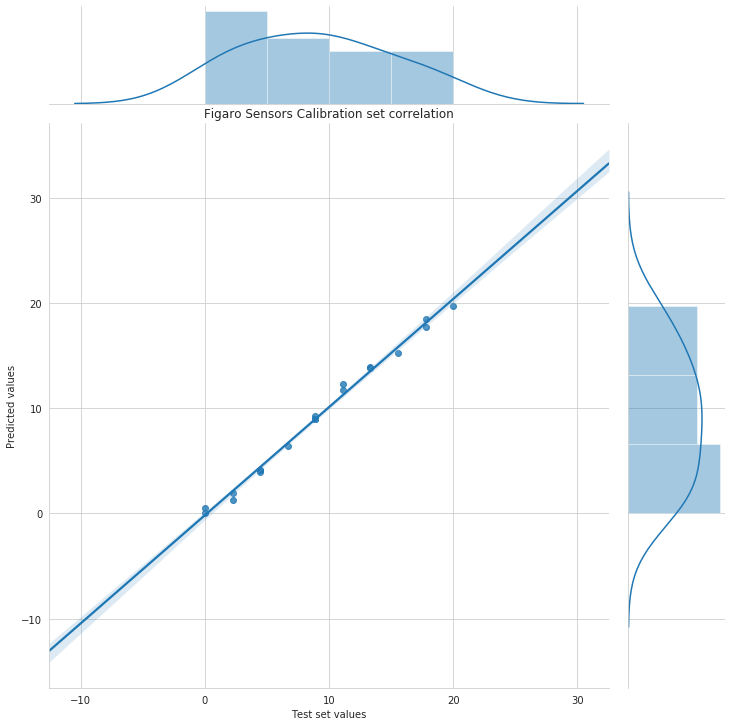

In [10]:
from sklearn import model_selection
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

signals = calibration_features_matrix

X = cal_experiment_matrix
y = cal_targets

test_size = 0.2
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=42)

latent_vars = 5
pls = PLSRegression(n_components=latent_vars)
pls.fit(X_train, y_train)

n = len(X_test)
Y_pred = np.array(pls.predict(X_test)).reshape(n)
y_test = np.array(y_test).reshape(n)
rmse = np.sqrt(mean_squared_error(y_test, Y_pred))
p, residuals, rank, singular_values, rcond = np.polyfit(y_test, Y_pred, 1, full=True)
results = sm.OLS(y_test, Y_pred).fit()
print("Slope: " + str(p[0]) + "\nIntercept: " + str(p[1]))
print("")
print('Root mean squared error: ' + str(rmse))
print("")
print(results.summary())

# Correlation plot
sns.jointplot(y_test,Y_pred, kind='reg', height=10)
plt.title("Figaro Sensors Calibration set correlation")
plt.ylabel("Predicted values")
plt.xlabel("Test set values")
plt.savefig('images/cal_corr.png',dpi=100)
plt.show()

# Model validation
Suggesting long term stability of output quality

Postprocessing data matrix into subtarget concentration samples ..
Postprocessing done.
Root mean squared error: 0.5188301477110349
Slope: 0.9920731620171164
Intercept: -0.1310510622776612

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          5.919e+04
Date:                Thu, 19 Sep 2019   Prob (F-statistic):                   2.65e-139
Time:                        11:21:58   Log-Likelihood:                         -67.833
No. Observations:                 100   AIC:                                      137.7
Df Residuals:                      99   BIC:                                      140.3
Df Model:                           1                                                  
Covariance Type:  

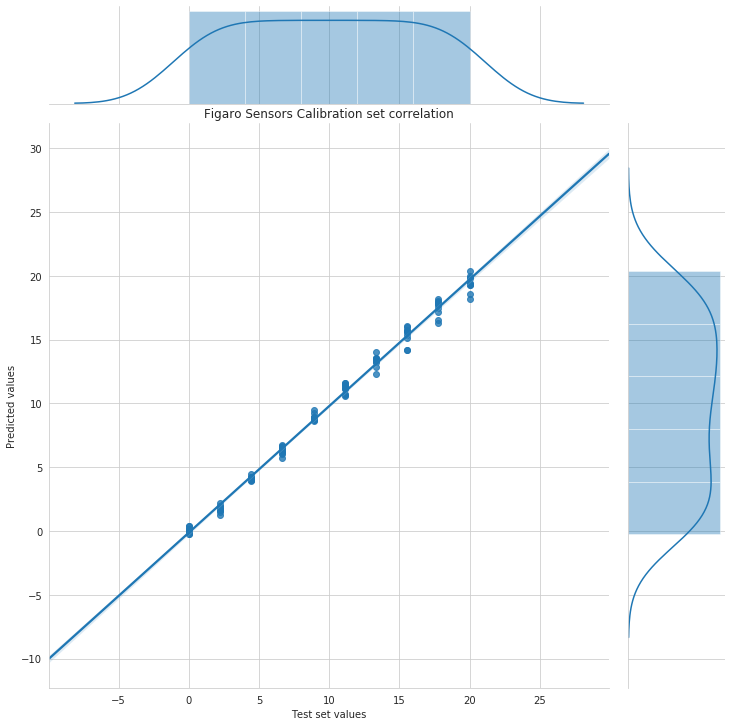

In [30]:
day = 13
val_experiment_matrix, val_targets = sensordata.postprocess_data(features_sets[day-1], target_sets[day-1])
X = val_experiment_matrix
y = val_targets
n = len(X)
Y_pred = np.array(pls.predict(X)).reshape(n)
y_eval = np.array(y).reshape(n)

rmse = np.sqrt(mean_squared_error(y_eval, Y_pred))
p, residuals, rank, singular_values, rcond = np.polyfit(y_eval,Y_pred, 1, full=True)
results = sm.OLS(Y_pred,y_eval).fit()
print('Root mean squared error: ' + str(rmse))
print("Slope: " + str(p[0]) + "\nIntercept: " + str(p[1]))
print("")
print(results.summary())

# Correlation plot
sns.jointplot(y_eval,Y_pred, kind='reg', height=10)
plt.title("Figaro Sensors Calibration set correlation")
plt.ylabel("Predicted values")
plt.xlabel("Test set values")
plt.savefig('images/val_corr.png',dpi=100)
plt.show()

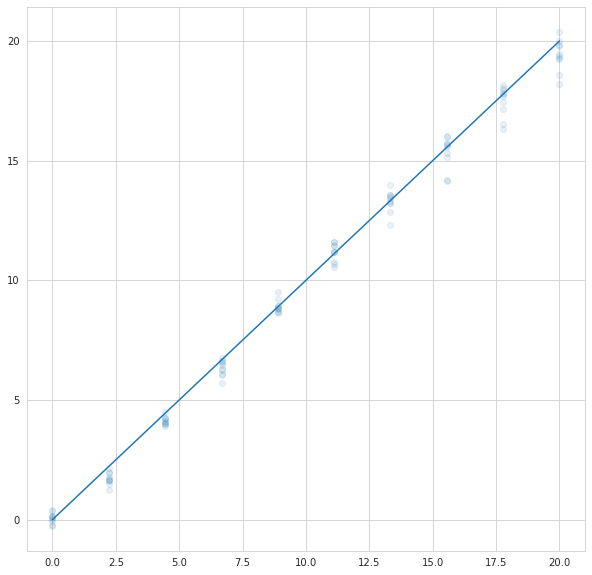

In [31]:
x = y_eval
y = Y_pred.reshape(len(Y_pred))
plt.figure(figsize=(10,10))
plt.scatter(x,y,alpha=0.1)
plt.plot(np.arange(0,21),np.arange(0,21))
plt.show()